# Simple edge graph
* task: "Create a network diagram that demonstrates how users move between chapters across all books within the dataset."
* Explanation: Build an edge list from the dataframe, whereby an edge list consists of a source and target column, which shows how users have moved between the network via chapters in books. So for a single row, the source would show the current book being read and the target would show the next book they are about to read.

The dataset we will be using for this project contains information on the reading habits of users of the online books for Manning publications, with 5000 entries within the dataset. The key information contained in each row of the dataset is as follows:
* user_id: A unique identifier for each user
* number_of_ticks: number of server ticks (each tick is 30 seconds) during which a user reads the book (technically, while the user has the chapter open)
* date_created: The date and time when the book was read.
* chapter: What chapter was read
* book: What book was read
* numberofentriesofbook: Number of referenced points of the book
* numberofusersofbook: Number of users who read the book
* product_manning_id: The unique product identifier from Manning
* user_owns_book: Whether the user owns the book

In [46]:
import random
from collections import Counter
from dateutil.parser import parse

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from networkx.algorithms.centrality import betweenness_centrality

In [125]:
df = pd.read_csv('dataset.csv')
# drop quote marks
df['date_created']= df['date_created'].apply(lambda x: x.replace('"', ''))
# convert to datetime
df['date_created']= df['date_created'].apply(parse)
# create combined column: (book, chapter)
df['book_ch'] = list(zip(df['book'], df['chapter']))
df.head()

,user_id,number_of_ticks,date_created,chapter,book,numberofentriesofbook,numberofusersofbook,product_manning_id,user_owns_book,book_ch
0,-2147277864,1,2019-10-27 08:58:15,chapter-8,bhargava,888,440,610,1,"(bhargava, chapter-8)"
1,-2146355313,8,2019-12-14 10:05:50,chapter-8,fain3,737,225,1069,1,"(fain3, chapter-8)"
2,-2146355313,8,2019-12-14 10:05:50,chapter-1,ramamurthy,715,202,1120,1,"(ramamurthy, chapter-1)"
3,-2146355313,8,2019-12-14 10:05:50,chapter-1,thomas,445,136,816,1,"(thomas, chapter-1)"
4,-2146168866,2,2019-11-27 05:09:29,about-this-book,prasanna,21,14,273,0,"(prasanna, about-this-book)"


In [126]:
edges = []
prevrow = None
for idx, row in df.sort_values(["user_id", "date_created"]).iterrows():
    if prevrow is not None and row["user_id"] == prevrow['user_id']:
        edges.append((prevrow["book_ch"], row["book_ch"]))        
    prevrow = row 
len(df), len(edges)        

(4999, 4358)

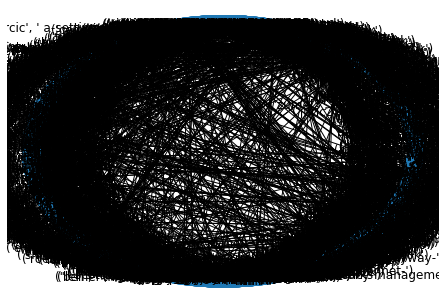

In [127]:
graph = nx.Graph()
graph.add_edges_from(edges)
nx.draw_shell(graph, with_labels=True)

## A large hair doesn't make a good graph viz

## Some other viz

In [128]:
len(df['date_created'].unique()), len(df['user_id'].unique())

(4990, 641)

## Book activity & popularity follows a Power Law distribution

windmill     162
elgendy      134
skeet5       103
mcnamara      99
chollet       91
            ... 
marmanis       1
carnell2       1
hilton         1
derosa         1
ellnestam      1
Name: book, Length: 334, dtype: int64


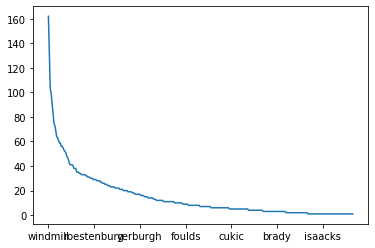

In [129]:
print(df.book.value_counts())
df.book.value_counts().plot()

## Let's Graph the activity of the top 10 books

In [130]:
N=10
book_cnt = Counter(df['book'].tolist())
topN  =[ book for book, cnt in  book_cnt.most_common(N)]
len(book_cnt), book_cnt.most_common(N)[-1]

(334, ('jain', 64))

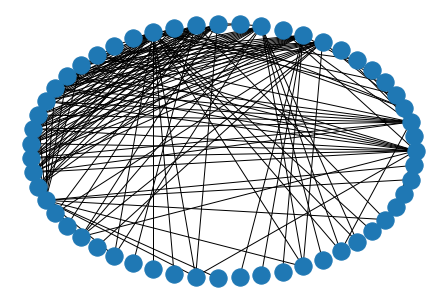

In [131]:
graph = nx.Graph()

for idx, row in tqdm(df[df.book.isin(topN)].iterrows()):    
    graph.add_edge(row['book'], row['chapter'])

nx.draw_shell(graph)

# User activity also seems to follow a Power Law distribution, surprisingly

In [132]:
df.user_id.value_counts()

-2021139802    653
-2088445927    331
-2074479722    106
-2135041721    104
-2074434789     89
              ... 
-2143668293      1
-2107430987      1
-2052315239      1
-2066245765      1
-2146168866      1
Name: user_id, Length: 641, dtype: int64

## Let's take a fairly active user and graph the interactions

In [133]:
frequent_user_id =  -2135041721
graph = nx.Graph()
for idx, row in tqdm(df.query(f"user_id =={frequent_user_id}").iterrows() ):    
    graph.add_edge(row['user_id'], row['book'])
    graph.add_edge(row['book'], row['book_ch'])

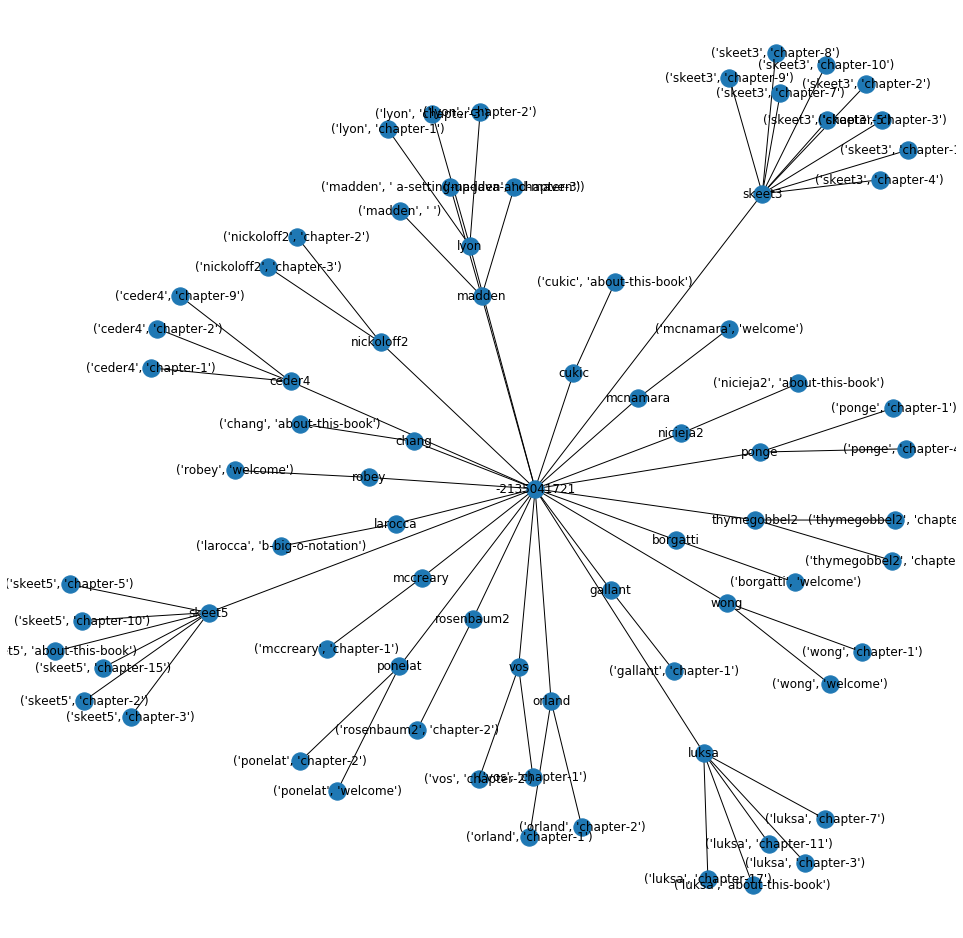

In [134]:
fig = plt.figure(figsize=(17,17))
ax = fig.gca()
nx.draw(graph,  with_labels=True) 

## Even this graph is cluttered with many single node edges, let's try to trim some

In [48]:
nodevals= betweenness_centrality(graph)
nodevals

{-2135041721: 0.9543859649122807,
 'skeet3': 0.22421052631578944,
 ('skeet3', 'chapter-5'): 0.0,
 'ponge': 0.05228070175438596,
 ('ponge', 'chapter-1'): 0.0,
 ('ponge', 'chapter-4'): 0.0,
 'gallant': 0.02631578947368421,
 ('gallant', 'chapter-1'): 0.0,
 'skeet5': 0.1526315789473684,
 ('skeet5', 'chapter-2'): 0.0,
 'wong': 0.05228070175438596,
 ('wong', 'welcome'): 0.0,
 'nicieja2': 0.02631578947368421,
 ('nicieja2', 'about-this-book'): 0.0,
 'lyon': 0.07789473684210525,
 ('lyon', 'chapter-1'): 0.0,
 'ponelat': 0.05228070175438596,
 ('ponelat', 'welcome'): 0.0,
 'mcnamara': 0.02631578947368421,
 ('mcnamara', 'welcome'): 0.0,
 'vos': 0.05228070175438596,
 ('vos', 'chapter-1'): 0.0,
 ('vos', 'chapter-2'): 0.0,
 'luksa': 0.12807017543859647,
 ('luksa', 'chapter-17'): 0.0,
 ('lyon', 'chapter-2'): 0.0,
 ('lyon', 'chapter-3'): 0.0,
 ('wong', 'chapter-1'): 0.0,
 'orland': 0.05228070175438596,
 ('orland', 'chapter-1'): 0.0,
 ('orland', 'chapter-2'): 0.0,
 ('skeet5', 'chapter-15'): 0.0,
 'thymeg

In [ ]:
# weak: 'mccreary': 0.02631578947368421,
# solid: 'madden': 0.07789473684210525,
# threshold? 'nickoloff2': 0.05228070175438596,

In [49]:
nodevals[-2135041721]

0.9543859649122807

In [54]:
books_in_graph = [tmp for tmp in nodevals.keys() if not isinstance(tmp, tuple)]
books_in_graph
books_below_threshold = [ book for book in books_in_graph if nodevals[book] < 0.053]
len(books_below_threshold)
threshold_set = set(books_below_threshold)
bookch_in_graph = [tmp for tmp in nodevals.keys()
                  if isinstance(tmp, tuple) 
                  and tmp[0] in threshold_set]

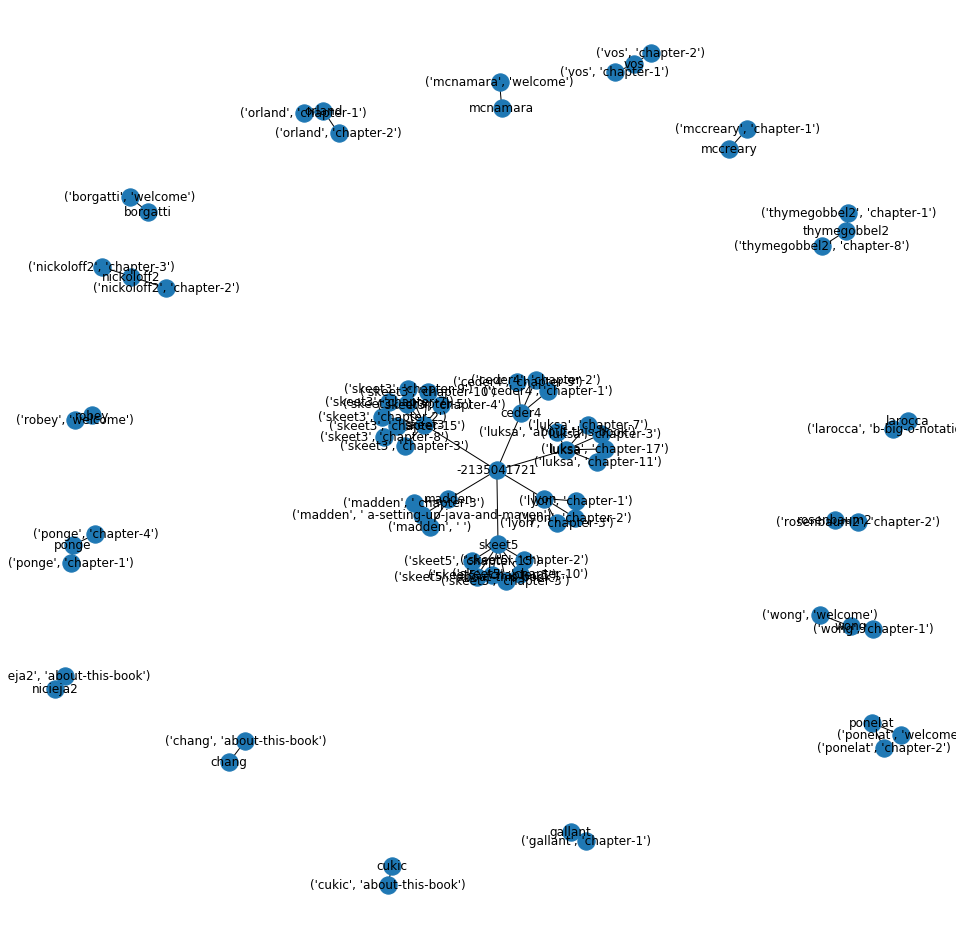

In [55]:
frequent_user_id = -2135041721
graph = nx.Graph()
for idx, row in tqdm(df.query(f"user_id == {frequent_user_id}").iterrows()):    
    graph.add_edge(row['user_id'], row['book'])
    graph.add_edge(row['book'], row['book_ch'])
nodevals = betweenness_centrality(graph)
graph.remove_edges_from( 
    list(zip([frequent_user_id] * len(books_below_threshold), books_below_threshold ))
+ bookch_in_graph
)
fig = plt.figure(figsize=(17,17))
ax = fig.gca()
nx.draw(graph,  with_labels=True) 

## The graph would look better with the strays deleted.

In [56]:
bookch_in_graph

[('ponge', 'chapter-1'),
 ('ponge', 'chapter-4'),
 ('gallant', 'chapter-1'),
 ('wong', 'welcome'),
 ('nicieja2', 'about-this-book'),
 ('ponelat', 'welcome'),
 ('mcnamara', 'welcome'),
 ('vos', 'chapter-1'),
 ('vos', 'chapter-2'),
 ('wong', 'chapter-1'),
 ('orland', 'chapter-1'),
 ('orland', 'chapter-2'),
 ('thymegobbel2', 'chapter-1'),
 ('thymegobbel2', 'chapter-8'),
 ('ponelat', 'chapter-2'),
 ('nickoloff2', 'chapter-2'),
 ('larocca', 'b-big-o-notation'),
 ('borgatti', 'welcome'),
 ('nickoloff2', 'chapter-3'),
 ('mccreary', 'chapter-1'),
 ('robey', 'welcome'),
 ('rosenbaum2', 'chapter-2'),
 ('chang', 'about-this-book'),
 ('cukic', 'about-this-book')]